# Setup

In [2]:
!git clone https://github.com/facebookresearch/ImageBind
%cd ImageBind
!pip install -q .

Cloning into 'ImageBind'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 117 (delta 45), reused 35 (delta 33), pack-reused 51
Receiving objects: 100% (117/117), 2.64 MiB | 10.85 MiB/s, done.
Resolving deltas: 100% (52/52), done.
/content/ImageBind
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.1/890.1 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 6.1 MB/s eta 0:00:00
 

# Load model

In [3]:
import numpy as np
import torch
import IPython.display as ipd
import matplotlib.pyplot as plt

from imagebind import data
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

# Set device to CUDA if available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Instantiate and prepare the model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


  0%|          | 0.00/4.47G [00:00<?, ?B/s]

ImageBindModel(
  (modality_preprocessors): ModuleDict(
    (vision): RGBDTPreprocessor(
      (cls_token): tensor((1, 1, 1280), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Sequential(
          (0): PadIm2Video()
          (1): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
      )
      (pos_embedding_helper): SpatioTemporalPosEmbeddingHelper(
        (pos_embed): tensor((1, 257, 1280), requires_grad=True)
        
      )
    )
    (text): TextPreprocessor(
      (pos_embed): tensor((1, 77, 1024), requires_grad=True)
      (mask): tensor((77, 77), requires_grad=False)
      
      (token_embedding): Embedding(49408, 1024)
    )
    (audio): AudioPreprocessor(
      (cls_token): tensor((1, 1, 768), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10), bias=False)
        (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=

# Example: Image retrieval by audio

In [4]:
# Define file paths
image_paths = [".assets/car_image.jpg"]
audio_paths = [".assets/dog_audio.wav", ".assets/car_audio.wav", ".assets/bird_audio.wav"]

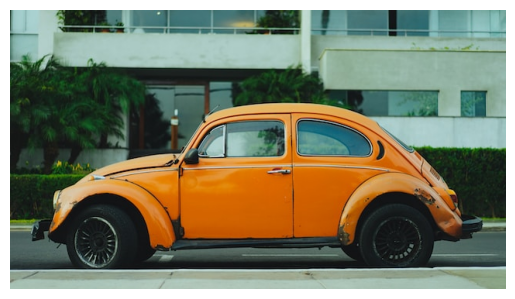

In [5]:
# Display images
for img_path in image_paths:
    img = plt.imread(img_path)
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [6]:
# Play audio files
for audio_path in audio_paths:
    ipd.display(ipd.Audio(audio_path))

Output hidden; open in https://colab.research.google.com to view.

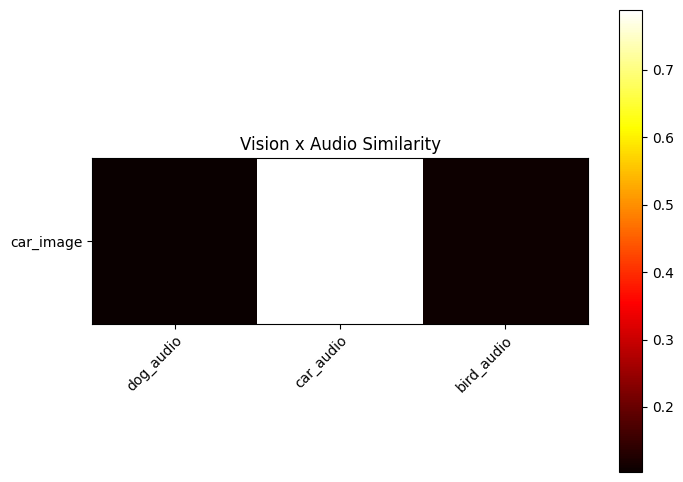

In [14]:
# Load and transform data
inputs = {
    ModalityType.VISION: data.load_and_transform_vision_data(image_paths, device),
    ModalityType.AUDIO: data.load_and_transform_audio_data(audio_paths, device),
}

# Compute embeddings
with torch.no_grad():
    embeddings = model(inputs)

# Compute similarity scores
vision_audio_similarity = torch.softmax(embeddings[ModalityType.VISION] @ embeddings[ModalityType.AUDIO].T, dim=-1)

# Define labels for the audio and vision data
audio_labels = ["dog_audio", "car_audio", "bird_audio"]
vision_labels = ["car_image"]

# Modified plot_similarity_chart function with labels
def plot_similarity_chart(similarity_matrix, title, x_labels, y_labels):
    plt.figure(figsize=(8, 6))
    ax = plt.gca()  # Get the current axes
    im = ax.imshow(similarity_matrix, cmap='hot', interpolation='nearest')

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_yticks(np.arange(len(y_labels)))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Add colorbar
    plt.colorbar(im)

    plt.title(title)
    plt.show()

plot_similarity_chart(vision_audio_similarity.cpu().numpy(), "Vision x Audio Similarity", audio_labels, vision_labels)